# Model Evaluation & Comparison
Compare NIC, BLIP, and Custom model captions using BLEU scores

In [9]:
import os
import csv
import json
import random
import re
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# HuggingFace models
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from transformers import BlipProcessor, BlipForConditionalGeneration

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {DEVICE}")

Using: cuda


## 1. Load Test Data

In [10]:
# Paths
IMAGES_DIR = "flickr30k_data/flickr30k_images/flickr30k_images"
CAPTIONS_FILE = "flickr30k_data/flickr30k_images/results.csv"

# Load captions
raw_captions = defaultdict(list)
with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    reader = csv.reader(f, delimiter='|')
    next(reader)
    for row in reader:
        if len(row) >= 3:
            img_id = row[0].strip()
            caption = row[2].strip() if len(row) > 2 else row[1].strip()
            raw_captions[img_id].append(caption.lower())

# Get test set (last 15%)
all_ids = list(raw_captions.keys())
random.seed(42)
random.shuffle(all_ids)
test_ids = all_ids[int(0.85 * len(all_ids)):]

# Sample for faster evaluation
N_SAMPLES = 100  # Adjust as needed
test_sample = random.sample(test_ids, min(N_SAMPLES, len(test_ids)))

print(f"Test images: {len(test_sample)}")

Test images: 100


## 2. Load Models

In [11]:
# --- NIC Model ---
print("Loading NIC...")
nic_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
nic_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
nic_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

def generate_nic(image):
    pixel_values = nic_processor(images=image, return_tensors="pt").pixel_values
    output_ids = nic_model.generate(pixel_values, max_length=16, num_beams=4)
    return nic_tokenizer.decode(output_ids[0], skip_special_tokens=True).lower()

Loading NIC...


In [12]:
# --- BLIP Model ---
print("Loading BLIP...")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def generate_blip(image):
    inputs = blip_processor(image, return_tensors="pt")
    out = blip_model.generate(**inputs, max_new_tokens=50)
    return blip_processor.decode(out[0], skip_special_tokens=True).lower()

Loading BLIP...


In [13]:
# --- Custom Model ---
print("Loading Custom...")

class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, att_dim):
        super().__init__()
        self.enc_att = nn.Linear(enc_dim, att_dim)
        self.dec_att = nn.Linear(dec_dim, att_dim)
        self.full_att = nn.Linear(att_dim, 1)
    def forward(self, enc, dec):
        att = self.full_att(torch.relu(self.enc_att(enc) + self.dec_att(dec).unsqueeze(1)))
        alpha = torch.softmax(att, dim=1)
        return (enc * alpha).sum(dim=1), alpha

class Decoder(nn.Module):
    def __init__(self, att_dim, emb_dim, dec_dim, vocab_size, enc_dim=2048):
        super().__init__()
        self.enc_dim = enc_dim
        self.vocab_size = vocab_size
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTMCell(emb_dim + enc_dim, dec_dim)
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)
        self.fc = nn.Linear(dec_dim, vocab_size)

# Load
with open('backend/vocab.json') as f:
    vocab = json.load(f)
word2idx = vocab['word2idx']
idx2word = {int(k): v for k, v in vocab['idx2word'].items()}

checkpoint = torch.load('backend/custom_caption_model.pth', map_location=DEVICE)

resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
custom_encoder = nn.Sequential(*list(resnet.children())[:-2]).to(DEVICE).eval()

custom_decoder = Decoder(
    checkpoint['attention_dim'], checkpoint['embed_dim'],
    checkpoint['decoder_dim'], checkpoint['vocab_size']
).to(DEVICE)
custom_decoder.load_state_dict(checkpoint['model_state_dict'])
custom_decoder.eval()

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def generate_custom(image, max_len=20):
    img = custom_transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        features = custom_encoder(img)
        enc_out = features.permute(0,2,3,1).view(1,-1,2048)
        h = custom_decoder.init_h(enc_out.mean(1))
        c = custom_decoder.init_c(enc_out.mean(1))
        
        words = []
        word_idx = word2idx['<start>']
        
        for _ in range(max_len):
            emb = custom_decoder.embedding(torch.tensor([word_idx]).to(DEVICE))
            ctx, _ = custom_decoder.attention(enc_out, h)
            h, c = custom_decoder.lstm(torch.cat([emb, ctx], 1), (h, c))
            logits = custom_decoder.fc(h)
            word_idx = logits.argmax(1).item()
            
            if word_idx == word2idx['<end>']:
                break
            if word_idx != word2idx['<start>']:
                words.append(idx2word[word_idx])
        
        return ' '.join(words)

print("All models loaded!")

Loading Custom...
All models loaded!


## 3. Evaluate on Test Set

In [14]:
def calc_bleu(reference_list, hypothesis):
    """Calculate BLEU-1,2,3,4 scores."""
    refs = [r.split() for r in reference_list]
    hyp = hypothesis.split()
    smooth = SmoothingFunction().method1
    
    return {
        'BLEU-1': sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smooth),
        'BLEU-2': sentence_bleu(refs, hyp, weights=(0.5,0.5,0,0), smoothing_function=smooth),
        'BLEU-3': sentence_bleu(refs, hyp, weights=(0.33,0.33,0.33,0), smoothing_function=smooth),
        'BLEU-4': sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth),
    }

# Run evaluation
results = {'NIC': [], 'BLIP': [], 'Custom': []}
examples = []

for img_id in tqdm(test_sample, desc="Evaluating"):
    img_path = os.path.join(IMAGES_DIR, img_id)
    if not os.path.exists(img_path):
        continue
    
    image = Image.open(img_path).convert('RGB')
    refs = raw_captions[img_id]
    
    # Generate captions
    try:
        nic_cap = generate_nic(image)
        blip_cap = generate_blip(image)
        custom_cap = generate_custom(image)
        
        results['NIC'].append(calc_bleu(refs, nic_cap))
        results['BLIP'].append(calc_bleu(refs, blip_cap))
        results['Custom'].append(calc_bleu(refs, custom_cap))
        
        if len(examples) < 5:
            examples.append({'id': img_id, 'refs': refs[0], 'NIC': nic_cap, 'BLIP': blip_cap, 'Custom': custom_cap})
    except Exception as e:
        print(f"Error {img_id}: {e}")

print(f"\nEvaluated {len(results['NIC'])} images")

Evaluating: 100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


Evaluated 100 images


In [17]:
# Aggregate scores
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)

for model_name, scores in results.items():
    if not scores:
        continue
    avg = {k: np.mean([s[k] for s in scores]) for k in ['BLEU-1','BLEU-2','BLEU-3','BLEU-4']}
    print(f"\n{model_name}:")
    print(f"  BLEU-1: {avg['BLEU-1']:.4f}")
    print(f"  BLEU-2: {avg['BLEU-2']:.4f}")
    print(f"  BLEU-3: {avg['BLEU-3']:.4f}")
    print(f"  BLEU-4: {avg['BLEU-4']:.4f}")


MODEL COMPARISON RESULTS

NIC:
  BLEU-1: 0.5747
  BLEU-2: 0.3733
  BLEU-3: 0.2257
  BLEU-4: 0.1464

BLIP:
  BLEU-1: 0.5210
  BLEU-2: 0.3713
  BLEU-3: 0.2519
  BLEU-4: 0.1733

Custom:
  BLEU-1: 0.5876
  BLEU-2: 0.4109
  BLEU-3: 0.2790
  BLEU-4: 0.1892


## 4. Test on Example Images

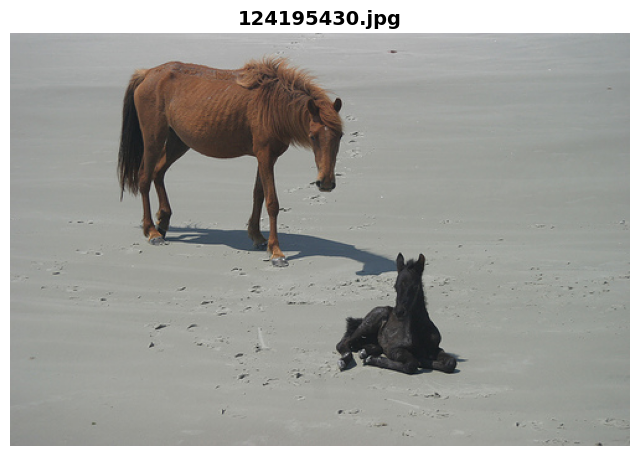


📷 124195430.jpg
   Ground Truth: a large brown horse stands over a small black colt that is kneeling on the sand .
                 a brown horse stands near a black horse that is sitting on the ground .
                 a thin brown horse standing and a small black horse sitting on sand .
                 an adult horse approaching a foal on a sandy plain .
                 a brown horse and a black foal on the beach
   NIC:          a brown horse and a black horse standing on a beach 
   BLIP:         a horse and a dog on the beach
   Custom:       a brown horse is running on the beach
----------------------------------------------------------------------


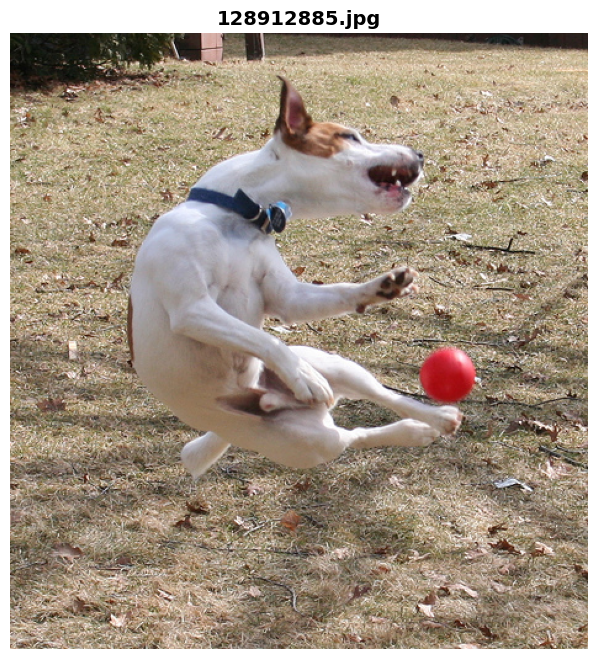


📷 128912885.jpg
   Ground Truth: a white dog is jumping in the air attempting to catch a red ball .
                 a white dog with a blue collar plays with a red ball .
                 a dog jumps for a red ball on the grass .
                 a white dog jumping to catch a red ball .
                 the dog is playing with a red ball .
   NIC:          a dog jumping in the air to catch a frisbee 
   BLIP:         a dog playing with a red ball in a yard
   Custom:       a white dog is jumping up to catch a red ball
----------------------------------------------------------------------


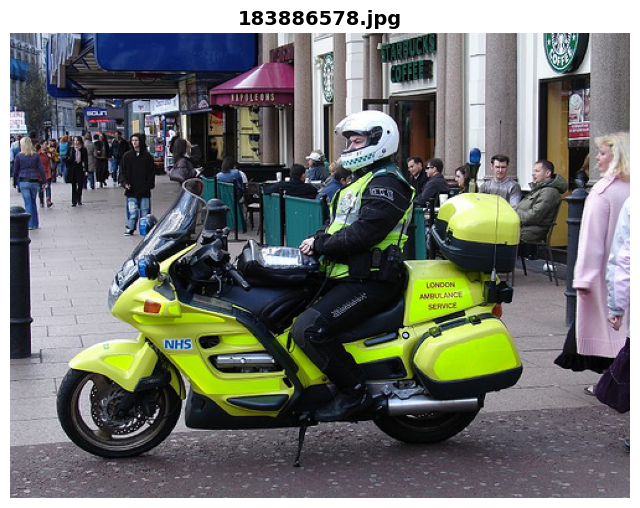


📷 183886578.jpg
   Ground Truth: a man wearing a white helmet and green and black jacket is riding on a bright green and yellow motorcycle , as people mill about him .
                 an authority-figure in a white helmet , wearing a yellow vest , and sitting on a yellow motorcycle .
                 a man on a lime green motorcycle , near a busy marketplace .
                 someone sitting on a yellow motorcycle .
                 a london ambulance motorcycle .
   NIC:          a police officer riding on the back of a motorcycle 
   BLIP:         a police officer on a motorcycle
   Custom:       a police officer is riding a motorcycle
----------------------------------------------------------------------


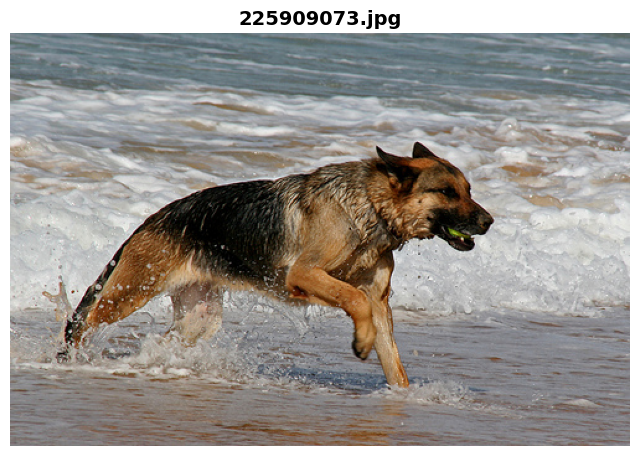


📷 225909073.jpg
   Ground Truth: a wet german shepherd dog is running out of the ocean with a ball in its mouth .
                 the german shepherd is walking in the body of water .
                 a black and brown dog is running out of the surf .
                 a wet dog runs through the surf at a beach .
                 german shepherd running in ocean surf
   NIC:          a dog running across a body of water 
   BLIP:         a dog running in the water
   Custom:       a german shepherd runs through the ocean
----------------------------------------------------------------------


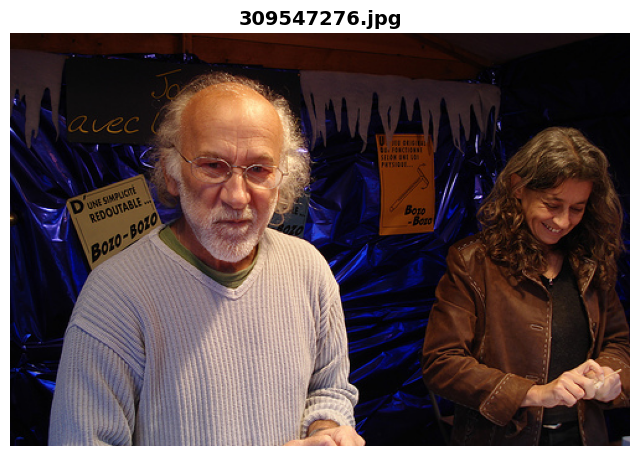


📷 309547276.jpg
   Ground Truth: before a blue background , a balding , white-haired bearded man with eyeglasses stands near a long-haired woman wearing a brown jacket and black top .
                 a man wearing a white sweater , has gray hair and beard and wears glasses stands next to a smiling woman wearing a brown jacket .
                 a man with a gray beard is standing next to a woman in a brown jacket .
                 an old man staring into the camera while a lady laughs .
                 an older man stands next to a woman who is laughing .
   NIC:          a man standing next to a woman in a room 
   BLIP:         a man wearing a brown jacket
   Custom:       a man in a blue shirt and a woman in a blue shirt are standing in front of a blue
----------------------------------------------------------------------


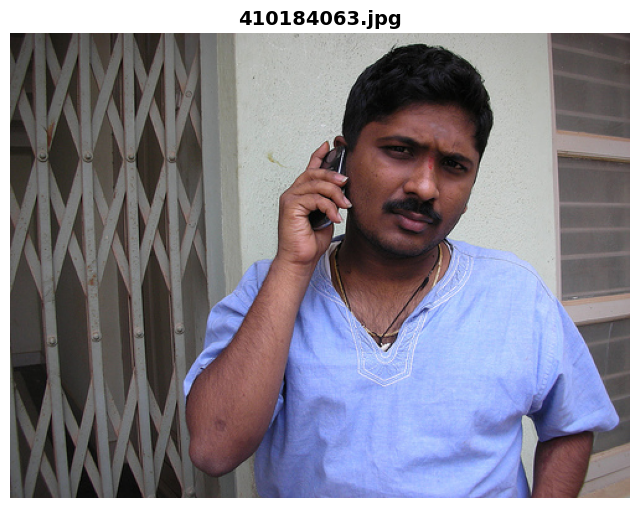


📷 410184063.jpg
   Ground Truth: a man with dark hair and a mustache is wearing a light blue shirt while talking on a cellphone .
                 man wearing blue shirt holds a cellphone against his ear .
                 man in a blue shirt with a mustache talking on a cellphone
                 a man with a mustache talking on a cellphone .
                 an indian man talks on his cellphone .
   NIC:          a man talking on a cell phone in front of a window 
   BLIP:         a man talking on a cell
   Custom:       a man in a blue shirt is holding a cellphone
----------------------------------------------------------------------


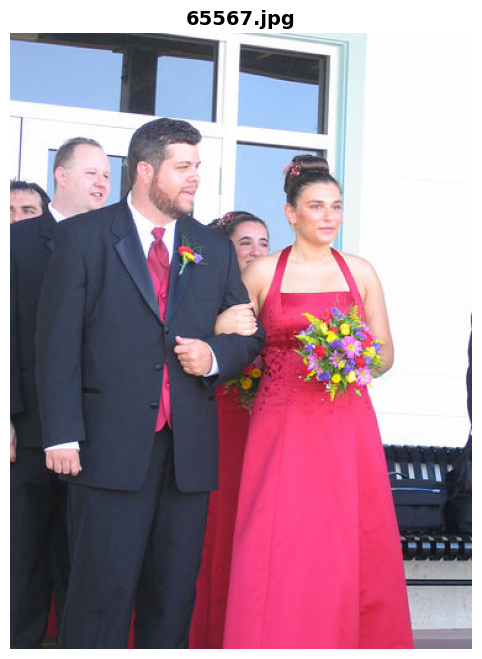


📷 65567.jpg
   Ground Truth: a bearded man , and a girl in a red dress are getting married .
                 the group of people are assembling for a wedding .
                 a man and woman dressed for a wedding function .
                 a woman holds a man 's arm at a formal event .
                 a wedding party walks out of a building .
   NIC:          a man and a woman standing next to each other 
   BLIP:         a man and woman in formal attire walking down the aisle
   Custom:       a bride and groom are standing in front of a building
----------------------------------------------------------------------


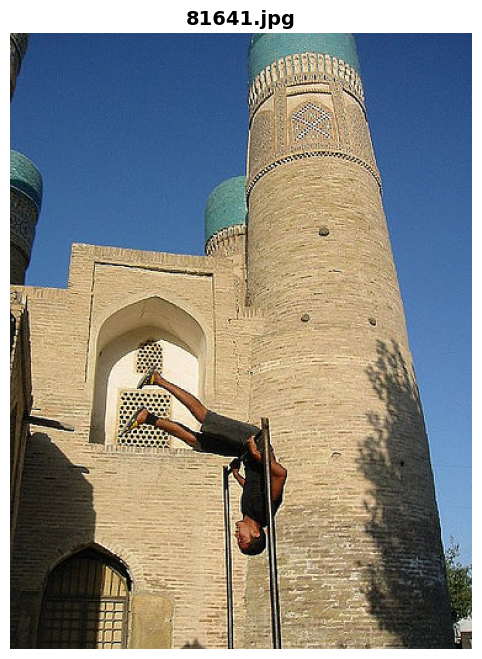


📷 81641.jpg
   Ground Truth: a man does acrobatics outside of a middle eastern style building .
                 a man is upside down on an outside gymnastics bar .
                 the man is flipping over the bar .
                 a man is upside-down on a pole .
                 a man doing gymnastic stunts
   NIC:          a man standing on top of a brick building 
   BLIP:         a man doing a handstant in front of a building
   Custom:       a man is jumping off a pole
----------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt

EXAMPLES_DIR = 'examples'
example_images = [
    '124195430.jpg', '128912885.jpg', '183886578.jpg', '225909073.jpg',
    '309547276.jpg', '410184063.jpg', '65567.jpg', '81641.jpg'
]

for img_name in example_images:
    img_path = os.path.join(EXAMPLES_DIR, img_name)
    if not os.path.exists(img_path):
        print(f"\n{img_name}: NOT FOUND")
        continue
    
    image = Image.open(img_path).convert('RGB')
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(img_name, fontsize=14, fontweight='bold')
    plt.show()
    
    # Get ground truth if available
    ground_truth = raw_captions.get(img_name, ["No ground truth available"])
    
    try:
        nic_cap = generate_nic(image)
        blip_cap = generate_blip(image)
        custom_cap = generate_custom(image)
        
        print(f"\n📷 {img_name}")
        print(f"   Ground Truth: {ground_truth[0]}")
        if len(ground_truth) > 1:
            for gt in ground_truth[1:]:
                print(f"                 {gt}")
        print(f"   NIC:          {nic_cap}")
        print(f"   BLIP:         {blip_cap}")
        print(f"   Custom:       {custom_cap}")
        print("-" * 70)
    except Exception as e:
        print(f"\n{img_name}: Error - {e}")